# Computing PET

In [1]:
import calendar
from pathlib import Path

import geopandas as gpd
import pandas as pd
import pydaymet as daymet
import xarray as xr
from hymod import compute_kge

In [2]:
import warnings

warnings.filterwarnings("ignore", message=".*Index.*")

`PyDaymet` offers three methods for computing PET: `penman_monteith`, `priestley_taylor`, and `hargreaves_samani`. Let's compute PET using `PyDaymet` with these three methods and compare them with
the [CAMELS](https://ral.ucar.edu/solutions/products/camels).

We choose station ID of 01013500 and time period of 2000-01-01 to 2009-01-12.

In [3]:
station = "01013500"
coords = (-68.58264, 47.23739)
dates = ("2000-01-01", "2009-01-12")
root = Path("input_data")

In [4]:
clm_par = Path(root, f"{station}_clm_single_pixel.parquet")
clm_nc = Path(root, f"{station}_clm_basin.nc")
basin = gpd.read_feather(Path(root, f"{station}_basin.feather"))

if clm_par.exists() and clm_nc.exists():
    clm_c = pd.read_parquet(clm_par)
    clm_b = xr.open_dataset(clm_nc)
else:
    clm_c = daymet.get_bycoords(coords, dates)
    clm_b = daymet.get_bygeom(basin.geometry[0], dates)
    clm_c.to_parquet(clm_par)
    clm_b.to_netcdf(clm_nc)

In [5]:
single, gridded, style = {}, {}, {}
methods = {"HS": "hargreaves_samani", "PM": "penman_monteith", "PT": "priestley_taylor"}
for n, m in methods.items():
    pet_c = daymet.potential_et(clm_c, coords, method=m)
    single[f"{n} (Single Pixel)"] = pet_c["pet (mm/day)"]
    style[f"{n} (Single Pixel)"] = "-"
    pet_b = daymet.potential_et(clm_b, method=m)
    gridded[f"{n} (Areal Average)"] = pet_b.pet.mean(dim=["x", "y"]).values
    style[f"{n} (Areal Average)"] = "--"

Now, let's get the CAMELS dataset and extract PET for our target station and time period.

In [6]:
camels = pd.read_parquet(Path(root, f"{station}_05_model_output.parquet"))
camels = camels.loc[clm_c.index, "PET"]
style["CAMELS"] = "-"

In [7]:
pet = pd.DataFrame({**single, **gridded, "CAMELS": camels})
pet[pet.lt(0)] = 0.0

Let's compute Kling-Gupta Efficiency (KGE) for each method in comparison to the CAMELS' results.

In [8]:
kge = {
    m: compute_kge(pet["CAMELS"].to_numpy("f8"), pet[m].to_numpy("f8"))
    for m in pet
    if m != "CAMELS"
}
pd.Series(kge, name="Kling-Gupta Efficiency")

HS (Single Pixel)     0.924996
PM (Single Pixel)     0.871693
PT (Single Pixel)     0.909878
HS (Areal Average)    0.910407
PM (Areal Average)    0.876787
PT (Areal Average)    0.929418
Name: Kling-Gupta Efficiency, dtype: float64

It seems that PT (Areal Average) performs better than the rest. We can plot the data for daily and mean-monthly PET.

<AxesSubplot:xlabel='time', ylabel='PET (mm/day)'>

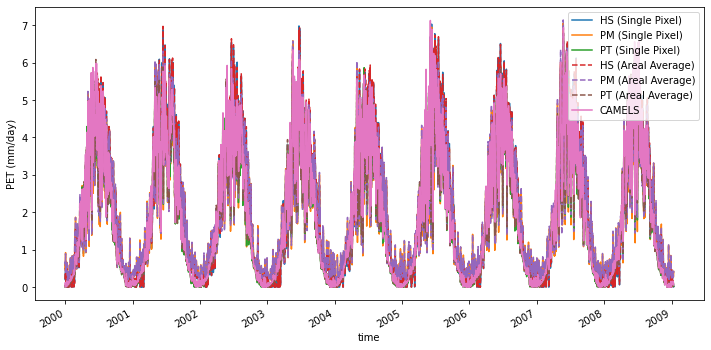

In [9]:
pet.plot(figsize=(12, 6), ylabel="PET (mm/day)", style=style)

In [10]:
month_abbr = dict(enumerate(calendar.month_abbr))
mean_month = pet.groupby(pd.Grouper(freq="M")).sum()
mean_month = mean_month.groupby(mean_month.index.month).mean()
mean_month.index = mean_month.index.map(month_abbr)

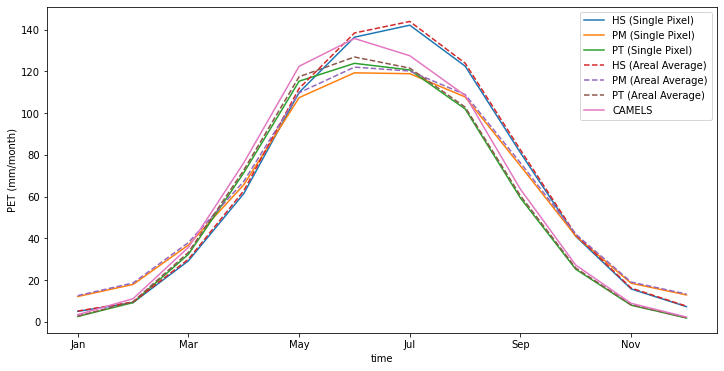

In [11]:
_ = mean_month.plot(figsize=(12, 6), ylabel="PET (mm/month)", style=style)